# What is in the Notebook #

This project includes modular Python scripts in the src/ directory that implement each stage of the data pipeline. For instructional clarity and reproducibility, this accompanying Jupyter notebook contains the same logic inline and demonstrates the full workflow end-to-end split up into 4 sections that represent the code in each .py file. This notebook serves as the primary execution and visualization environment, while the scripts provide a modular reference implementation consistent with the project rubric

# Notebook — Section 1: Get NOAA Data (Station Metadata and Timeseries) #

Purpose:
Scrape NOAA CO-OPs API for station metadata and data for the timeseries calculation

**Cell get_data.1: Imports**

In [40]:
#Cell get_data.1: Imports#
import os
import time
import requests
import sys
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta, timezone

**Cell get_data.2: Setup Directory and Configure Timeseries**

In [41]:
RAW_DATA_DIR = os.path.join("data", "raw")
TIMESERIES_DIR = os.path.join(RAW_DATA_DIR, "timeseries_cache")

os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(TIMESERIES_DIR, exist_ok=True)

DAYS_BACK = 30
SLEEP_BETWEEN_STATIONS_SEC = 0.2

**Cell get_data.3: Utility for this section**

In [42]:
def safe_get_json(url, params=None, timeout=20):
    try:
        r = requests.get(url, params=params, timeout=timeout)
        status = r.status_code
        text_head = (r.text or "")[:200]
        try:
            return r.json(), status, text_head
        except Exception:
            return None, status, text_head
    except Exception as e:
        return None, None, str(e)[:200]


def ensure_float_series(s):
    return pd.to_numeric(s, errors="coerce")


**Cell get_data.4 Defines function to fetch NOAA California station metadata (API)**

In [43]:
def fetch_noaa_ca_station_metadata():
    url = "https://api.tidesandcurrents.noaa.gov/mdapi/prod/webapi/stations.json"
    params = {
        "expand": "details,products,latlon",
        "type": "waterlevels"
    }

    data, status, head = safe_get_json(url, params=params)

    # If API fails, return empty so fallback is used
    if data is None or "stations" not in data:
        return pd.DataFrame(columns=["station_id", "station_name", "lat", "lon"])

    df = pd.DataFrame(data["stations"]).copy()

    # Normalize ID and name
    rename_map = {}
    if "id" in df.columns:
        rename_map["id"] = "station_id"
    if "name" in df.columns:
        rename_map["name"] = "station_name"

    df = df.rename(columns=rename_map)

    # ---- LATITUDE ----
    lat_col = None
    for c in ["lat", "latitude", "lat_dd", "lt"]:
        if c in df.columns:
            lat_col = c
            break

    # ---- LONGITUDE ----
    lon_col = None
    for c in ["lon", "lng", "longitude", "lon_dd", "ln"]:
        if c in df.columns:
            lon_col = c
            break

    # If either coordinate is missing, bail out safely
    if lat_col is None or lon_col is None:
        return pd.DataFrame(columns=["station_id", "station_name", "lat", "lon"])

    # Rename to standard names
    df = df.rename(columns={lat_col: "lat", lon_col: "lon"})

    # Optional state filter
    if "state" in df.columns:
        df = df[df["state"] == "CA"].copy()

    # Convert types safely
    df["lat"] = ensure_float_series(df["lat"])
    df["lon"] = ensure_float_series(df["lon"])

    # Drop rows without valid coordinates
    df = df.dropna(subset=["station_id", "station_name", "lat", "lon"])

    return df[["station_id", "station_name", "lat", "lon"]].reset_index(drop=True)


**Cell get_data.5: Creates Fallback station list in case of API mistake**

In [44]:
def fallback_ca_station_list():
    return pd.DataFrame([
        {"station_id": "9410170", "station_name": "San Diego", "lat": 32.7142, "lon": -117.1736},
        {"station_id": "9410230", "station_name": "La Jolla", "lat": 32.8669, "lon": -117.2571},
        {"station_id": "9410660", "station_name": "Los Angeles", "lat": 33.7197, "lon": -118.2722},
        {"station_id": "9410840", "station_name": "Santa Monica", "lat": 34.0083, "lon": -118.5000},
        {"station_id": "9411340", "station_name": "Santa Barbara", "lat": 34.4033, "lon": -119.6920},
        {"station_id": "9412110", "station_name": "Port San Luis", "lat": 35.1683, "lon": -120.7540},
        {"station_id": "9413450", "station_name": "Monterey", "lat": 36.6050, "lon": -121.8883},
        {"station_id": "9414290", "station_name": "San Francisco", "lat": 37.8063, "lon": -122.4659},
        {"station_id": "9416841", "station_name": "Arena Cove", "lat": 38.9140, "lon": -123.7110},
        {"station_id": "9418767", "station_name": "North Spit", "lat": 40.7667, "lon": -124.2167},
        {"station_id": "9419750", "station_name": "Crescent City", "lat": 41.7456, "lon": -124.1839},
    ])

**Cell get_data.6: Save Raw station metadata from API to data/raw**

In [45]:
stations_df = fetch_noaa_ca_station_metadata()

if stations_df.empty:
    stations_df = fallback_ca_station_list()

stations_path = os.path.join(RAW_DATA_DIR, "ca_noaa_stations.csv")
stations_df.to_csv(stations_path, index=False)

stations_df.head()


,station_id,station_name,lat,lon
0,9410170,San Diego,32.715557,-117.17667
1,9410230,La Jolla,32.866890,-117.25714
2,9410660,Los Angeles,33.720000,-118.27200
3,9410840,Santa Monica,34.008300,-118.50000
4,9411340,Santa Barbara,34.404590,-119.69250


**Cell get_data.7: Fetch water-level timeseries for each station**

In [46]:
def fetch_water_level_timeseries(station_id, days_back=DAYS_BACK):
    end = datetime.now(timezone.utc)
    start = end - timedelta(days=days_back)

    datums_to_try = ["MSL", "MLLW", "NAVD"]
    url = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"

    for datum in datums_to_try:
        params = {
            "product": "water_level",
            "application": "CA_Coastal_Project",
            "station": station_id,
            "begin_date": start.strftime("%Y%m%d"),
            "end_date": end.strftime("%Y%m%d"),
            "datum": datum,
            "time_zone": "gmt",
            "units": "metric",
            "format": "json",
        }

        data, status, _ = safe_get_json(url, params=params)

        if status != 200 or data is None or "data" not in data:
            continue

        df = pd.DataFrame(data["data"])
        if "t" not in df.columns or "v" not in df.columns:
            continue

        df["datetime"] = pd.to_datetime(df["t"], utc=True, errors="coerce")
        df["water_level_m"] = ensure_float_series(df["v"])
        df = df[["datetime", "water_level_m"]].dropna()

        if len(df) >= 30:
            return df

    return None

**Cell get_data.8: saves timereis data to data/raw**

In [47]:
for _, row in stations_df.iterrows():
    station_id = row["station_id"]
    print("Downloading water levels for:", station_id)

    ts_df = fetch_water_level_timeseries(station_id)
    time.sleep(SLEEP_BETWEEN_STATIONS_SEC)

    if ts_df is None or ts_df.empty:
        continue

    ts_path = os.path.join(
        TIMESERIES_DIR,
        f"{station_id}_water_level.csv"
    )
    ts_df.to_csv(ts_path, index=False)


# Notebook — Section 2: Clean Data (Clean Station data, Integrate Housing data) #

Purpose:
Prepare the data in data/raw and data/processed for run_analysis.py to use, integrate housing data from sklearn.datasets

**Cell clean_data.1: Imports**

In [11]:
import os
import pandas as pd
import numpy as np

from pathlib import Path
from sklearn.datasets import fetch_california_housing
from sklearn.neighbors import KDTree

**Cell clean_data.2: Directory Configuration**

In [12]:
RAW_DATA_DIR = os.path.join("data", "raw")
PROCESSED_DATA_DIR = os.path.join("data", "processed")

TIMESERIES_DIR = os.path.join(RAW_DATA_DIR, "timeseries_cache")

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

**Cell clean_data.3: Load station metadata from data/raw**

In [13]:
stations_path = os.path.join(RAW_DATA_DIR, "ca_noaa_stations.csv")

stations_df = pd.read_csv(stations_path)

stations_df.head()


,station_id,station_name,lat,lon
0,9410170,San Diego,32.715557,-117.17667
1,9410230,La Jolla,32.866890,-117.25714
2,9410660,Los Angeles,33.720000,-118.27200
3,9410840,Santa Monica,34.008300,-118.50000
4,9411340,Santa Barbara,34.404590,-119.69250


**Cell clean_data.4: Load raw water-level timeseries into memory**

In [14]:
def load_timeseries_cache(timeseries_dir):
    timeseries = {}

    for fname in os.listdir(timeseries_dir):
        if not fname.endswith("_water_level.csv"):
            continue

        station_id = fname.replace("_water_level.csv", "")
        path = os.path.join(timeseries_dir, fname)

        df = pd.read_csv(path, parse_dates=["datetime"])
        timeseries[station_id] = df

    return timeseries


In [15]:
timeseries_dict = load_timeseries_cache(TIMESERIES_DIR)

len(timeseries_dict)

17

**Cell clean_data.5: Prepare CA housing data, not in get_data.py because we used the pre-defined fetch_ca_housing_data function from sklearn.datasets**

In [16]:
cal = fetch_california_housing(as_frame=True)

housing_df = cal.frame.copy()
housing_df["latitude"] = housing_df["Latitude"]
housing_df["longitude"] = housing_df["Longitude"]

housing_df = housing_df[["latitude", "longitude", "MedHouseVal"]]

housing_df.head()

,latitude,longitude,MedHouseVal
0,37.88,-122.23,4.526
1,37.86,-122.22,3.585
2,37.85,-122.24,3.521
3,37.85,-122.25,3.413
4,37.85,-122.25,3.422


**Cell clean_data.6: Attatch nearest housing value index to tide stations**

In [17]:
def attach_housing_data_to_stations(stations_df, housing_df):
    station_coords = stations_df[["lat", "lon"]].to_numpy()
    housing_coords = housing_df[["latitude", "longitude"]].to_numpy()

    tree = KDTree(housing_coords)
    distances, indices = tree.query(station_coords, k=1)

    stations_df = stations_df.copy()
    stations_df["MedHouseVal"] = housing_df.iloc[indices.flatten()]["MedHouseVal"].to_numpy()
    stations_df["nearest_housing_distance_deg"] = distances.flatten()

    return stations_df


In [18]:
stations_with_housing = attach_housing_data_to_stations(
    stations_df,
    housing_df
)

stations_with_housing.head()


,station_id,station_name,lat,lon,MedHouseVal,nearest_housing_distance_deg
0,9410170,San Diego,32.715557,-117.17667,2.62500,0.008014
1,9410230,La Jolla,32.866890,-117.25714,5.00001,0.009922
2,9410660,Los Angeles,33.720000,-118.27200,2.34500,0.012806
3,9410840,Santa Monica,34.008300,-118.50000,5.00001,0.010143
4,9411340,Santa Barbara,34.404590,-119.69250,5.00000,0.005960


**Cell clean_data.7: Saved cleaned station metadata to data/processed**

In [19]:
processed_path = os.path.join(
    PROCESSED_DATA_DIR,
    "stations_with_housing.csv"
)

stations_with_housing.to_csv(processed_path, index=False)

processed_path

'data/processed/stations_with_housing.csv'

# Notebook — Section 3: Run Analysis (Trends and Risk) #

Purpose:
Compute sea-level trends from raw time series, combine with housing data, and calculate a coastal risk score.

**Cell run_analysis.1: Imports and Paths**

In [20]:
import os
import numpy as np
import pandas as pd

from pathlib import Path

RAW_DATA_DIR = os.path.join("data", "raw")
PROCESSED_DATA_DIR = os.path.join("data", "processed")

TIMESERIES_DIR = os.path.join(RAW_DATA_DIR, "timeseries_cache")

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

**Cell run_analysis.2: Load cleaned station data from clean_data.py**

In [21]:
stations_path = os.path.join(
    PROCESSED_DATA_DIR,
    "stations_with_housing.csv"
)

stations_df = pd.read_csv(stations_path)

stations_df.head()

,station_id,station_name,lat,lon,MedHouseVal,nearest_housing_distance_deg
0,9410170,San Diego,32.715557,-117.17667,2.62500,0.008014
1,9410230,La Jolla,32.866890,-117.25714,5.00001,0.009922
2,9410660,Los Angeles,33.720000,-118.27200,2.34500,0.012806
3,9410840,Santa Monica,34.008300,-118.50000,5.00001,0.010143
4,9411340,Santa Barbara,34.404590,-119.69250,5.00000,0.005960


**Cell run_analysis.3: Load water-level timeseries data from get_data.py**

In [22]:
def load_timeseries_cache(timeseries_dir):
    timeseries = {}

    for fname in os.listdir(timeseries_dir):
        if not fname.endswith("_water_level.csv"):
            continue

        station_id = fname.replace("_water_level.csv", "")
        path = os.path.join(timeseries_dir, fname)

        df = pd.read_csv(path, parse_dates=["datetime"])
        timeseries[station_id] = df

    return timeseries

In [23]:
timeseries_dict = load_timeseries_cache(TIMESERIES_DIR)

len(timeseries_dict)

17

**Cell run_analysis.4: Compute linear sea-level trend in meters/year**

In [24]:
def compute_linear_trend_m_per_year(ts_df):
    df = ts_df.copy().dropna()

    if len(df) < 30:
        return np.nan, np.nan

    t0 = df["datetime"].min()
    df["time_s"] = (df["datetime"] - t0).dt.total_seconds()

    if df["time_s"].nunique() < 2:
        return np.nan, np.nan

    slope_m_per_s, intercept = np.polyfit(
        df["time_s"].to_numpy(),
        df["water_level_m"].to_numpy(),
        1
    )

    slope_m_per_year = slope_m_per_s * 60 * 60 * 24 * 365
    return slope_m_per_year, intercept

**Cell run_analysis.5: Build station-level trend table**

In [25]:
trend_records = []

for _, row in stations_df.iterrows():
    station_id = str(row["station_id"])
    ts = timeseries_dict.get(station_id)

    if ts is None or ts.empty:
        continue

    slope, intercept = compute_linear_trend_m_per_year(ts)

    if np.isnan(slope):
        continue

    trend_records.append({
        "station_id": station_id,
        "station_name": row["station_name"],
        "lat": row["lat"],
        "lon": row["lon"],
        "trend_m_per_year": slope,
        "trend_intercept": intercept,
        "MedHouseVal": row["MedHouseVal"],
        "nearest_housing_distance_deg": row["nearest_housing_distance_deg"],
        "n_points": len(ts),
    })

In [26]:
trend_df = pd.DataFrame(trend_records)

trend_df.head()

,station_id,station_name,lat,lon,trend_m_per_year,trend_intercept,MedHouseVal,nearest_housing_distance_deg,n_points
0,9410170,San Diego,32.715557,-117.17667,-0.385104,0.159182,2.62500,0.008014,7414
1,9410230,La Jolla,32.866890,-117.25714,-0.176842,0.122678,5.00001,0.009922,7428
2,9410660,Los Angeles,33.720000,-118.27200,-0.498725,0.138154,2.34500,0.012806,7431
3,9410840,Santa Monica,34.008300,-118.50000,-0.342757,0.133571,5.00001,0.010143,7425
4,9411340,Santa Barbara,34.404590,-119.69250,-0.533338,0.144966,5.00000,0.005960,7438


**Cell run_analysis.6: Save station trend data to data/processed**

In [28]:
trend_out = os.path.join(
    PROCESSED_DATA_DIR,
    "combined_ca_water_levels.csv"
)

trend_df.to_csv(trend_out, index=False)

trend_out

'data/processed/combined_ca_water_levels.csv'

**Cell run_analysis.7: Normalize variables and compute risk score**

In [29]:
trend_df = trend_df.copy()

trend_df["trend_norm"] = trend_df["trend_m_per_year"] / trend_df["trend_m_per_year"].max()
trend_df["house_norm"] = trend_df["MedHouseVal"] / trend_df["MedHouseVal"].max()

trend_df["risk_score"] = trend_df["trend_norm"] * trend_df["house_norm"]

trend_df.head()

,station_id,station_name,lat,lon,trend_m_per_year,trend_intercept,MedHouseVal,nearest_housing_distance_deg,n_points,trend_norm,house_norm,risk_score
0,9410170,San Diego,32.715557,-117.17667,-0.385104,0.159182,2.62500,0.008014,7414,2.177675,0.524999,1.143277
1,9410230,La Jolla,32.866890,-117.25714,-0.176842,0.122678,5.00001,0.009922,7428,1.000000,1.000000,1.000000
2,9410660,Los Angeles,33.720000,-118.27200,-0.498725,0.138154,2.34500,0.012806,7431,2.820173,0.468999,1.322659
3,9410840,Santa Monica,34.008300,-118.50000,-0.342757,0.133571,5.00001,0.010143,7425,1.938211,1.000000,1.938211
4,9411340,Santa Barbara,34.404590,-119.69250,-0.533338,0.144966,5.00000,0.005960,7438,3.015905,0.999998,3.015899


**Cell run_analysis.8: Save final risk dataset to data/processed**

In [30]:
risk_out = os.path.join(
    PROCESSED_DATA_DIR,
    "combined_risk_data.csv"
)

trend_df.to_csv(risk_out, index=False)

risk_out

'data/processed/combined_risk_data.csv'

# Notebook — Section 4: Visualize Results #

Purpose:
Create plots and an interactive map from the processed analysis outputs.

**Cell visualize_results.1: Imports and output directories**

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium

from adjustText import adjust_text

In [32]:
PROCESSED_DATA_DIR = os.path.join("data", "processed")
OUTPUT_DIR = "results"

os.makedirs(OUTPUT_DIR, exist_ok=True)

**Cell visualize_results.2: Load processed analysis data**

In [33]:
risk_path = os.path.join(
    PROCESSED_DATA_DIR,
    "combined_risk_data.csv"
)

df = pd.read_csv(risk_path)

**Cell visualize_results.3: Scatter Plot - sea-level trend vs. housing value**

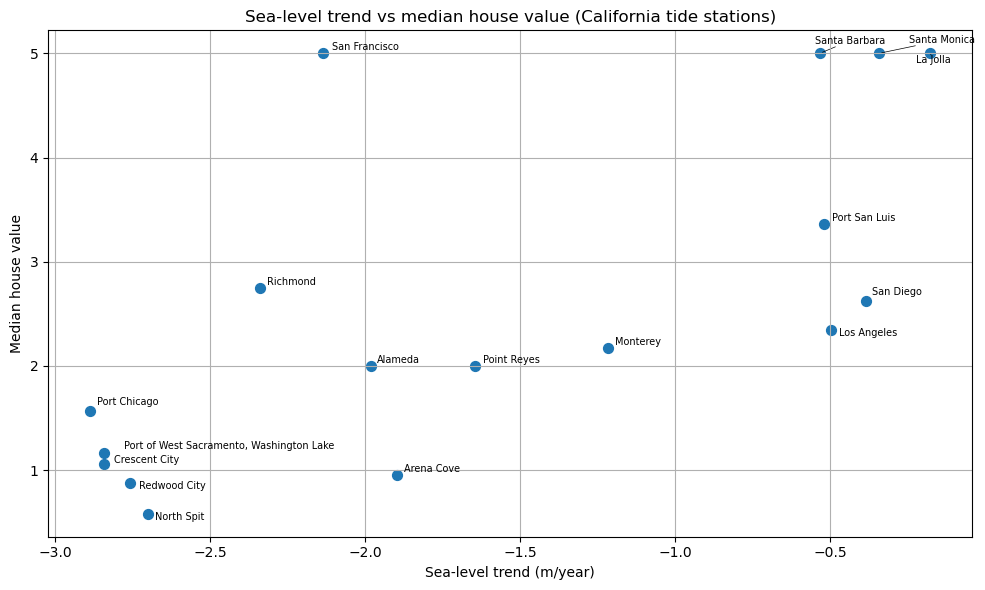

In [34]:
plt.figure(figsize=(10, 6))

plt.scatter(
    df["trend_m_per_year"],
    df["MedHouseVal"],
    s=50
)

plt.xlabel("Sea-level trend (m/year)")
plt.ylabel("Median house value")
plt.title("Sea-level trend vs median house value (California tide stations)")
plt.grid(True)

texts = []
for _, r in df.iterrows():
    texts.append(
        plt.text(
            r["trend_m_per_year"],
            r["MedHouseVal"],
            r["station_name"],
            fontsize=7
        )
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", lw=0.5))

scatter_out = os.path.join(
    OUTPUT_DIR,
    "scatter_trend_vs_housing.png"
)

plt.tight_layout()
plt.savefig(scatter_out, dpi=150)
plt.show()

**Cell visualize_results.4: Bar plot of risk score by station**

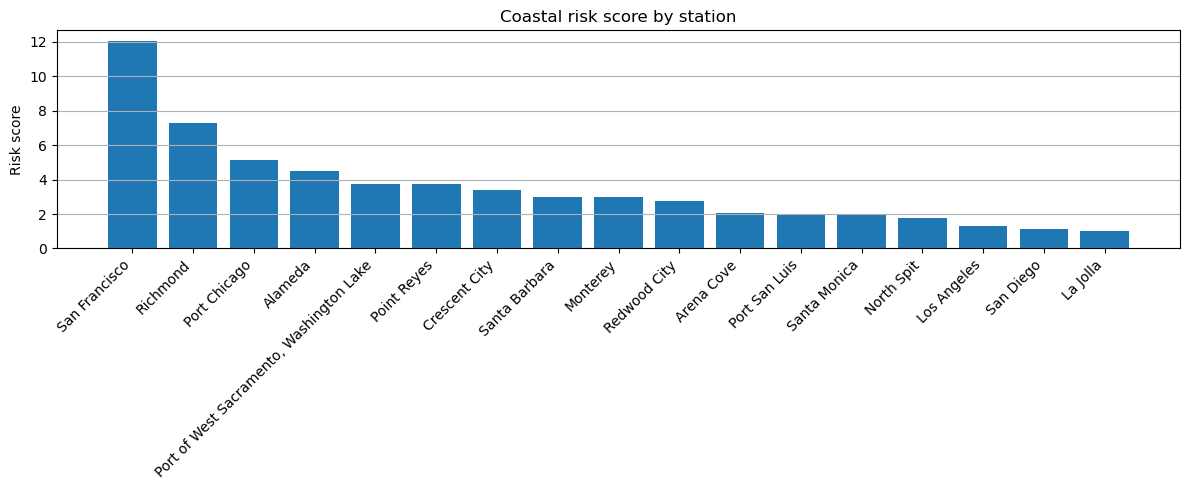

In [35]:
df_bar = df.sort_values("risk_score", ascending=False)

plt.figure(figsize=(12, 5))
plt.bar(df_bar["station_name"], df_bar["risk_score"])

plt.xticks(rotation=45, ha="right")
plt.ylabel("Risk score")
plt.title("Coastal risk score by station")
plt.grid(axis="y")

bar_out = os.path.join(
    OUTPUT_DIR,
    "bar_risk_scores.png"
)

plt.tight_layout()
plt.savefig(bar_out, dpi=150)

**Cell visualize_results.5: Line plot of sea-level rise trend by station**

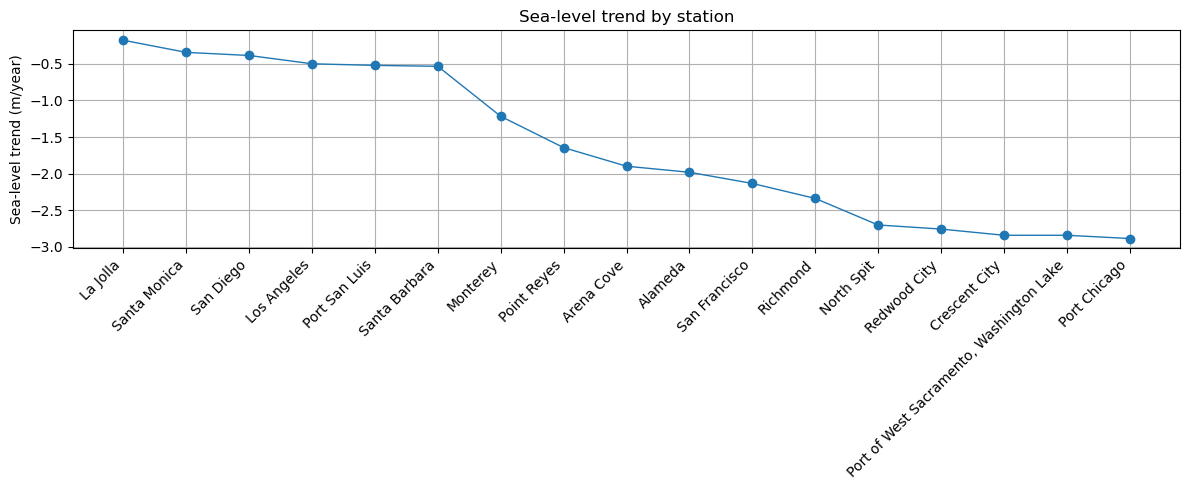

In [36]:
df_line = df.sort_values("trend_m_per_year", ascending=False)

plt.figure(figsize=(12, 5))
plt.plot(
    df_line["station_name"],
    df_line["trend_m_per_year"],
    marker="o",
    linewidth=1
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Sea-level trend (m/year)")
plt.title("Sea-level trend by station")
plt.grid(True)

line_out = os.path.join(
    OUTPUT_DIR,
    "line_trends.png"
)

plt.tight_layout()
plt.savefig(line_out, dpi=150)

**Cell visualize_results.6: Folium map**

In [48]:
lat_min, lat_max = df["lat"].min(), df["lat"].max()
lon_min, lon_max = df["lon"].min(), df["lon"].max()

center_lat = (lat_min + lat_max) / 2
center_lon = (lon_min + lon_max) / 2

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=6,
    tiles="OpenStreetMap"
)

m.fit_bounds([[lat_min, lon_min], [lat_max, lon_max]])

for _, r in df.iterrows():
    popup_text = (
        f"{r['station_name']}<br>"
        f"Trend (m/yr): {r['trend_m_per_year']:.6f}<br>"
        f"Risk score: {r['risk_score']:.3f}<br>"
        f"Median house value: {r['MedHouseVal']:.3f}"
    )

    folium.CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=5,
        color="red",
        fill=True,
        fill_opacity=0.6,
        popup=popup_text
    ).add_to(m)

map_out = os.path.join(
    OUTPUT_DIR,
    "ca_coastal_risk_map.html"
)

m.save(map_out)
m